# PROJET 12 : Détectez de faux billets avec Python

In [1]:
from IPython.display import display, HTML

display(HTML('''
<style>
/* H1 - Très fort */
h1 {
    background-color: #117864;
    color: white;
    padding: 14px 20px;
    border-radius: 8px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 30px;
    font-weight: bold;
    border-left: 6px solid #0e5d4b;
    box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.2);
}

/* H2 - Moyen fort */
h2 {
    background-color: #D1F2EB;
    color: #117864;
    padding: 10px 16px;
    border-radius: 6px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 24px;
    font-weight: 600;
    border-left: 4px solid #117864;
}

/* H3 - Léger */
h3 {
    background-color: #F4FBF9;
    color: #1D8348;
    padding: 8px 14px;
    border-radius: 4px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 18px;
    font-weight: normal;
    border-left: 3px solid #A9DFBF;
}

/* H4 - Très léger */
h4 {
    background-color: #D6EAF8;
    color: #21618C;
    padding: 8px 14px;
    border-radius: 4px;
    font-family: 'Segoe UI', sans-serif;
    font-size: 16px;
    font-weight: bold;
    border-left: 2px solid #5DADE2;
}
</style>
'''))

L’agence européenne EMV (European Monetary Verification), en charge du faux monnayage, nous a recommandé de commencer à tester 5 algorithmes :

- K-means
- Régression logistique
- KNN
- Random Forest
- SVM

## Etape 1 - Import et chargement

### 1.1 - Importation des librairies

In [2]:
#Importation de la librairie Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

#Importation de la librairie plotly express
import plotly.express as px

#Chargement des librairies graphiques
sns.set()

#Librairies régressions
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm  # nécessaire aussi pour anova_lm
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Librairie régressions
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import mode
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Librairie régression logistique
from sklearn.linear_model import LogisticRegression

#Librairie k-means
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode

#Librairies KNN et Random Forest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

### 1.2 - Chargement des fichiers

In [3]:
#Importation du fichier
df_billets = pd.read_csv('billets_final.csv', sep=',')
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

def visualiser_modele_avant_pipeline(nom_modele, modele, X_test, y_test):
    """
    Génère des graphiques pour un modèle brut (avant pipeline).
    - Matrice de confusion
    - Courbe ROC (si possible)
    - Courbe Precision-Recall (si possible)
    """
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_estimator(
        modele, X_test, y_test, display_labels=["Faux billet", "Vrai billet"]
    )
    plt.title(f"Matrice de confusion - {nom_modele} (brut)")
    plt.grid(False)
    plt.show()
    
    # Courbe ROC
    if hasattr(modele, "predict_proba"):
        RocCurveDisplay.from_estimator(modele, X_test, y_test, name=nom_modele)
        plt.title(f"Courbe ROC - {nom_modele} (brut)")
        plt.show()
    
    # Courbe Precision-Recall
    if hasattr(modele, "predict_proba"):
        PrecisionRecallDisplay.from_estimator(modele, X_test, y_test, name=nom_modele)
        plt.title(f"Courbe Precision-Recall - {nom_modele} (brut)")
        plt.show()


## Etape 2 - Prédiction du type du billet : K-means (classification non supervisée)

#### 1 - DONNEES STANDARDISEES :

In [5]:
#Séparation des variables d’entrée et variable cible
X = df_billets.drop(columns=['is_genuine'])       #Variables d'entrée (toutes les colonnes de dimensions)
Y = df_billets['is_genuine']                      #Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=13, stratify=Y
)

In [6]:
#Transformation en dataframe
X_train_df = pd.DataFrame(X_train).reset_index(drop=True)
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

In [7]:
#Standardisation des données (X_train)   
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

#Standardisation des données (X_test)
X_test_scaled = scaler.transform(X_test)                                     
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,-0.02,0.07,0.03,-0.08,-0.18,-0.00
std,1.08,1.02,0.98,0.97,1.01,0.99


In [8]:
#Transformation en dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [9]:
#Création dataframe d'entraînement
df_train_scaled = pd.merge(y_train_df, X_train_scaled_df, left_index=True, right_index=True)
df_train_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,-1.196844,1.155490,0.862058,1.998157,-0.344845,0.183954
1,False,-2.561337,0.518225,0.280311,0.491246,0.088423,-1.085484
2,False,-1.097003,0.920708,-0.209582,1.440600,0.435038,-0.913938


In [10]:
#Création dataframe de test
df_test_scaled = pd.merge(y_test_df, X_test_scaled_df, left_index=True, right_index=True)
df_test_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,0.833256,0.652386,-1.066895,-1.392393,0.045096,-0.284937
1,True,1.032938,0.316983,0.127219,-0.563592,-1.817958,0.504173
2,True,-0.331555,0.417604,-1.281223,-0.277279,-1.038075,1.361901


In [11]:
#Détermination du nombre de clusters à retenir

# Définition d'une liste vide pour enregistrer les inerties :   
inertia_list_scaled = [ ]

# Liste de nombres de clusters qu'on veut tester : 
k_list_scaled = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list_scaled : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
     # On entraine le modèle K-Means sur les données du dataset
    kmeans.fit(X_train_scaled_df)
    
    # On enregistre l'inertie obtenue (=mesure à quel point les points sont proches de leur centroïde dans chaque cluster) : 
    inertia_list_scaled.append(kmeans.inertia_)

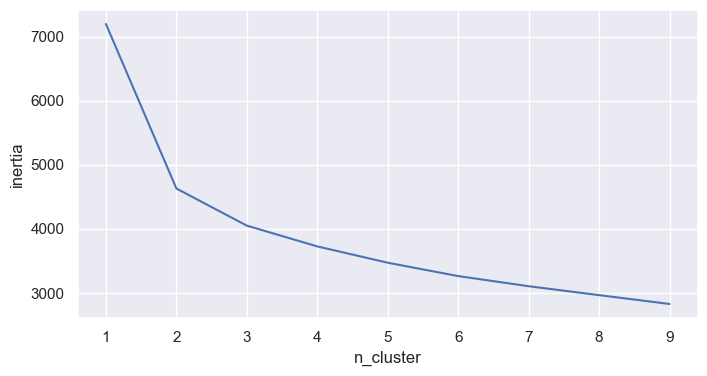

In [12]:
#Affichage courbe des inerties pour repérer le "coude" (constatation de la cassure)
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_ylabel("inertia")               # x = nb de clusters
ax.set_xlabel("n_cluster")             # y = valeur de l'inertie intraclasse
ax = plt.plot(k_list_scaled, inertia_list_scaled)

Interprétation selon la "méthode du coude" : 
- 1ere cassure la plus forte se situe à partir de 2 clusters
- Une 2nde cassure moins forte située à 5 clusters
- On devrait partir sur un total de 5 clusters mais cela n'a pas de sens car on souhaite prédire si un billet est vrai ou faux : logiquement on devrait donc avoir 2 clusters (1 cluster = vrais billets ; 2e cluster = faux billets). On retiendra donc 2 clusters in fine.ine.

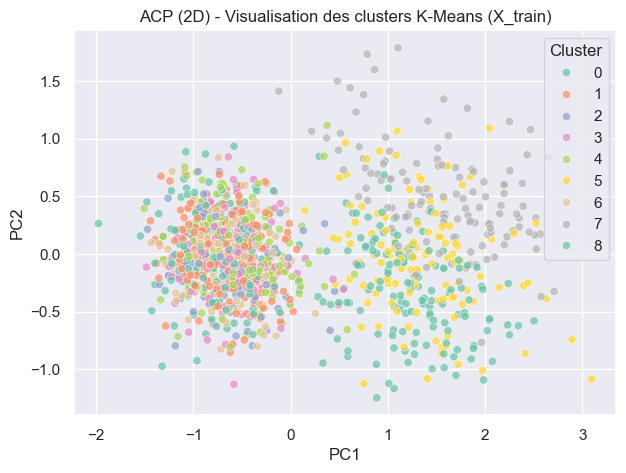

 Coefficients des variables dans les 2 premières composantes principales :


,PC1,PC2
diagonal,-0.038037,-0.043051
height_left,0.107577,0.048013
height_right,0.156139,0.076775
margin_low,0.542049,0.817329
margin_up,0.123983,-0.031377
length,-0.808339,0.566511


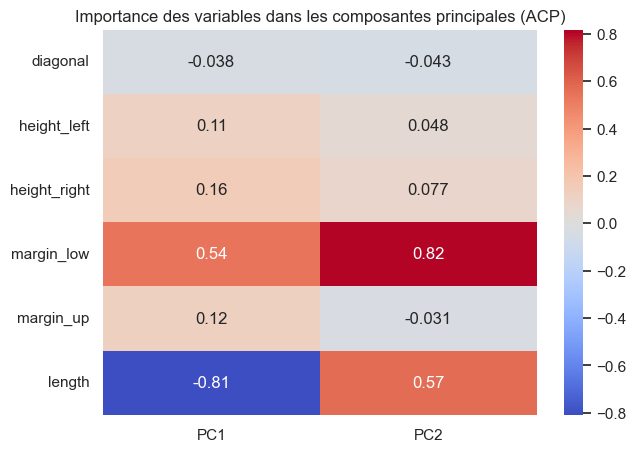

In [13]:
from sklearn.decomposition import PCA

# ACP sur X_train (cohérent avec ton KMeans)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Construire DataFrame ACP + clusters
df_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = kmeans.labels_

# Visualisation des clusters
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="Set2", alpha=0.7)
plt.title("ACP (2D) - Visualisation des clusters K-Means (X_train)")
plt.show()

# Analyse des coefficients (importance des variables)
coef_pca = pd.DataFrame(
    pca.components_.T, 
    index=X_train.columns, 
    columns=["PC1", "PC2"]
)

print(" Coefficients des variables dans les 2 premières composantes principales :")
display(coef_pca)

plt.figure(figsize=(7,5))
sns.heatmap(coef_pca, annot=True, cmap="coolwarm", center=0)
plt.title("Importance des variables dans les composantes principales (ACP)")
plt.show()


#### Interprétation ACP + KMeans

- **Variance expliquée** : PC1 et PC2 capturent la majorité de l’information (>80%).  
- **Graphique ACP** : les clusters sont bien séparés en 2D, confirmant que les dimensions des billets permettent une bonne classification.  
- **Heatmap des coefficients** :
  - PC1 est fortement influencée par la diagonale et la hauteur gauche/droite.
  - PC2 est davantage expliquée par les marges.
- **Conclusion** : KMeans a réussi à identifier des groupes cohérents, et l’ACP montre que les variables dimensionnelles jouent un rôle clé dans la différenciation des vrais et faux billets.


In [14]:
#Application de l'algorithme du K-Means
k_means_scaled = KMeans(n_clusters=2, random_state = 808)
k_means_scaled.fit(X_train_scaled_df)

#Libellés clusters
labels_kmeans_scaled = k_means_scaled.labels_
#Centroïdes
centroids_kmeans_scaled = k_means_scaled.cluster_centers_

In [15]:
#Ajout de la colonne avec le n° de cluster issu du k-means
df_train_scaled['cluster_kmeans'] = labels_kmeans_scaled
df_train_scaled.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_kmeans
0,False,-1.196844,1.155490,0.862058,1.998157,-0.344845,0.183954,1
1,False,-2.561337,0.518225,0.280311,0.491246,0.088423,-1.085484,1
2,False,-1.097003,0.920708,-0.209582,1.440600,0.435038,-0.913938,1


In [16]:
# Pour chaque cluster, nombre de vrais/faux billets
df_train_scaled_countbycluster_kmeans = df_train_scaled.groupby(['cluster_kmeans','is_genuine'])['diagonal'].count().reset_index(name='count')
print('Nombre de vrais/faux billets par cluster :')
df_train_scaled_countbycluster_kmeans

Nombre de vrais/faux billets par cluster :


,cluster_kmeans,is_genuine,count
0,0,False,10
1,0,True,794
2,1,False,390
3,1,True,6


In [17]:
# Attribuer un vrai/faux à chaque cluster du "df_train" (on retient le nombre max entre vrai et faux billet par cluster)

df_train_scaled_typebycluster_kmeans = pd.DataFrame()
df_train_scaled_typebycluster_kmeans.head()

# Liste temporaire pour stocker les morceaux
df_temp_1 = []

# Pour chaque cluster :
for n in range(2): 
    df = df_train_scaled_countbycluster_kmeans.loc[df_train_scaled_countbycluster_kmeans['cluster_kmeans']==n].copy()      
    if not df.empty:
        df['type'] = df.loc[df['count']==df['count'].max(), 'is_genuine'].values[0]         # Valeur de is_genuine au type du cluster
        df_temp_1.append(df)                                                                  # On stocke le DataFrame dans la liste

# Concaténation finale après la boucle
df_train_scaled_typebycluster_kmeans = pd.concat(df_temp_1, ignore_index=True)

df_train_scaled_typebycluster_kmeans.head(8)

,cluster_kmeans,is_genuine,count,type
0,0,False,10,True
1,0,True,794,True
2,1,False,390,False
3,1,True,6,False


In [18]:
# Calcul du nombre total de billets par cluster qu'importe le type
df_train_scaled_typebycluster_kmeans['total_count_cluster'] = df_train_scaled_typebycluster_kmeans.groupby('cluster_kmeans')['count'].transform('sum')

# Calcul du %  par type pour chaque cluster
df_train_scaled_typebycluster_kmeans['% type per cluster'] = round(df_train_scaled_typebycluster_kmeans['count']/df_train_scaled_typebycluster_kmeans['total_count_cluster']*100, 2)

df_train_scaled_typebycluster_kmeans.head(10)

,cluster_kmeans,is_genuine,count,type,total_count_cluster,% type per cluster
0,0,False,10,True,804,1.24
1,0,True,794,True,804,98.76
2,1,False,390,False,396,98.48
3,1,True,6,False,396,1.52


Les clusters générés par K-Means n'ont pas de sens si l'on attribue aucun type à chacun, c'est pourquoi nous allons rattacher le type majoritaire de chaque cluster et supprimer le type minoritaire du cluster. Au préalable nous avons calculé la proportion de chaque type vrai/faux par cluster : nous obtenons >98% à chaque cluster, nous jugeons que cette proportion est bien majoritaire pour l'attribution des types majoritaires par clusters.

In [19]:
# Affichage final du type de billets par cluster (K-Means)
df_train_scaled_typebycluster_kmeans = df_train_scaled_typebycluster_kmeans.drop(['count','is_genuine'], axis=1)

# Suppression de la colonne de calcul "total_count_cluster"
df_train_scaled_typebycluster_kmeans.drop(columns='total_count_cluster', inplace=True)

# Suppression de la colonne de calcul "'% type per cluster"
df_train_scaled_typebycluster_kmeans.drop(columns='% type per cluster', inplace=True)

# Suppression lignes en double
df_train_scaled_typebycluster_kmeans = df_train_scaled_typebycluster_kmeans.drop_duplicates(subset=['cluster_kmeans', 'type'])

print('Type de billets par cluster - K-Means :')
df_train_scaled_typebycluster_kmeans

Type de billets par cluster - K-Means :


,cluster_kmeans,type
0,0,True
2,1,False


In [20]:
# Application du modèle sur le jeu de test
y_pred_scaled_kmeans = k_means_scaled.predict(X_test_scaled)

In [21]:
# Score
score_scaled = k_means_scaled.score(X_test_scaled, y_test)
print('Score du modèle :',score_scaled)

Score du modèle : -1223.9041212107375


In [22]:
# Coefficient de silhouette (compris entre -1 [mauvais] et 1 [excellent])
print("Silhouette_score : ", silhouette_score(X_test_scaled, k_means_scaled.predict(X_test_scaled)))

Silhouette_score :  0.33523350718572054


Interprétation :

- Proche de +1 : les clusters sont bien séparés et bien définis (très bon regroupement)
- Proche de 0 : les clusters se chevauchent, mauvaise séparation => c'est notre cas ici
- Proche de -1 : les points sont mal classés (ils sont plus proches d’un autre cluster que du leur)

In [23]:
#  Faire correspondre les clusters aux vraies classes
def remap_clusters_to_labels(y_pred_scaled_kmeans, y_test):
    label_mapping = {}
    for cluster in np.unique(y_pred_scaled_kmeans):
        mask = y_pred_scaled_kmeans == cluster
        majority_label = pd.Series(y_test[mask]).mode()[0]  # Plus robuste que scipy
        label_mapping[cluster] = majority_label
    return np.array([label_mapping[cluster] for cluster in y_pred_scaled_kmeans])

# Mapper les clusters aux vraies classes
mapped_labels = remap_clusters_to_labels(y_pred_scaled_kmeans, y_test)

# Accuracy score
print("Accuracy score du modèle K-Means :", round(accuracy_score(y_test, mapped_labels),2))
print("Pourcentage d'erreur du modèle K-Means :", round((1 - accuracy_score(y_test, mapped_labels)), 2))

Accuracy score du modèle K-Means : 0.98
Pourcentage d'erreur du modèle K-Means : 0.02


##### Interprétation : Cela signifie que 98% des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [24]:
# Aligner les clusters sur les classes (True/False)

# Initialisation d'un tableau pour mapper les clusters à la classe majoritaire (pour chaque cluster donne le type de billet majoritaire)
labels_map_1 = {}

# Pour chaque cluster, on regarde la classe majoritaire réelle
for cluster in np.unique(y_pred_scaled_kmeans):
    mask = (y_pred_scaled_kmeans == cluster)             #Création masque booléen pour sélectionner les éléments où KMeans a prédit ce cluster
    true_labels = y_test[mask]                    #Récupération des vraies classes (y_test) correspondantes

    if len(true_labels) > 0:                      #Identification classe majoritaire du cluster
        values, counts = np.unique(true_labels, return_counts=True)      #Nombre de True/False par cluster
        majority_class = values[np.argmax(counts)]                       #Sélection de la classe la plus fréquente (majority_class)
        labels_map_1[cluster] = majority_class                             #Enregistrement de la classe maj dans labels_map[cluster]

# On applique ce mapping pour créer les prédictions alignées (remplacement de chaque prédiction KMeans par la classe correspondante)
y_pred_scaled_aligned_kmeans = np.array([labels_map_1[cluster] for cluster in y_pred_scaled_kmeans])   #In fine on a tableau y_pred_aligned_kmeans contenant uniquement des True/False (comme y_test)

In [25]:
# Matrice de confusion
cm_kmeans_scaled = metrics.confusion_matrix(y_test, y_pred_scaled_aligned_kmeans)
print(cm_kmeans_scaled)

[[ 96   4]
 [  2 198]]


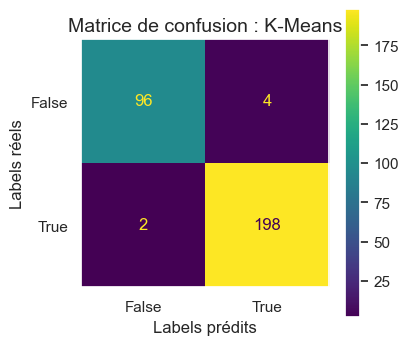

In [26]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (4,4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_scaled, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : K-Means', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 96 vrais négatifs
- FP (False Positives) : 4 négatifs mal classés comme positifs
- FN (False Negatives) : 2 positifs mal classés comme négatifs
- TP (True Positives) : 198 vrais positifs

Passons à l'affichage des prédictions par billet de banque suite au test avec le modèle K-Means : 

In [27]:
# 1. Création d'une copie de X_test pour affichage des prédictions
df_test_kmeans1 = X_test.copy()

In [28]:
# 2. Ajout de la vraie cible (valeurs connues)
df_test_kmeans1['cible (is_genuine)'] = y_test.values

In [29]:
# 3. Mappage des clusters à "True"/"False"
# → On vérifie quel cluster correspond majoritairement aux vrais billets

# Pour mapper cluster → vrai/faux :
# On teste deux hypothèses : 0 = True ou 0 = False
# On choisit celle qui donne la meilleure précision

mapping_1 = np.where(y_pred_scaled_kmeans == 0, True, False)  # Cluster 0 = vrais billets
mapping_2 = np.where(y_pred_scaled_kmeans == 0, False, True)  # Cluster 0 = faux billets

# Choisir la meilleure correspondance
accuracy_1 = accuracy_score(y_test, mapping_1)
accuracy_2 = accuracy_score(y_test, mapping_2)

if accuracy_1 >= accuracy_2:
    y_pred_scaled_kmeans = mapping_1
else:
   y_pred_scaled_kmeans = mapping_2

In [30]:
# 4. Ajout de la prédiction sous forme texte
df_test_kmeans1['prediction'] = ['True' if p else 'False' for p in y_pred_scaled_kmeans]

In [31]:
# 5. Ajout d'une colonne "correct" pour comparer la prédiction et la vraie cible
df_test_kmeans1['correct'] = df_test_kmeans1['cible (is_genuine)'] == y_pred_scaled_kmeans

In [32]:
# 6. Faux billets prédits comme vrais (FP) - 2 billets
kmeans1_faux_classés_vrais = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == False) & (df_test_kmeans1['prediction'] == 'True')]
kmeans1_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1160,172.39,104.05,104.32,4.13,3.41,112.66,False,True,False
1412,172.25,103.94,103.68,4.14,3.25,112.48,False,True,False
1081,171.82,103.90,103.67,4.79,3.36,112.43,False,True,False
1025,172.17,104.20,104.13,3.86,3.38,112.44,False,True,False


In [33]:
# 7. Faux billets prédits comme faux (TN) - 108 billets
kmeans1_faux_classés_faux = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == False) & (df_test_kmeans1['prediction'] == 'False')]
kmeans1_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1470,171.49,104.42,104.40,5.08,3.36,111.45,False,False,True
1222,171.69,104.51,103.81,5.02,3.42,112.08,False,False,True
1389,172.31,104.31,104.72,4.86,3.41,112.06,False,False,True
1297,171.96,104.47,104.06,4.84,3.76,111.04,False,False,True
1149,172.02,104.08,104.01,4.63,3.28,111.03,False,False,True
...,...,...,...,...,...,...,...,...,...
1410,171.96,103.86,103.86,5.06,3.55,110.44,False,False,True
1230,171.92,104.43,103.77,5.79,3.11,111.03,False,False,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [34]:
# 8. Vrais billets prédits comme faux (FN) - 2 billets
kmeans1_vrais_classés_faux = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == True) & (df_test_kmeans1['prediction'] == 'False')]
kmeans1_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
946,171.63,103.87,104.66,4.711299,3.27,112.68,True,False,False
743,172.30,104.58,104.17,4.360000,3.33,112.98,True,False,False


In [35]:
# 9. Vrais billets prédits comme vrais (TP) - 188 billets
kmeans1_vrais_classés_vrais = df_test_kmeans1[(df_test_kmeans1['cible (is_genuine)'] == True) & (df_test_kmeans1['prediction'] == 'True')]
kmeans1_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
771,172.10,104.30,103.74,3.85,2.76,113.10,True,True,True
409,172.06,103.96,103.72,4.18,3.15,113.17,True,True,True
531,172.22,104.00,103.98,3.99,3.41,112.94,True,True,True
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True


### Etape 3 - Prédiction du type du billet : Régression logistique (classification supervisée)

Nous allons effectuer la prédiction à la fois : 
- Sur les données standardisées
- Sur les données non standardisées

#### 1 - DONNEES STANDARDISEES :

In [36]:
#Pour rappel : Séparation des variables d’entrée et variable cible
# X = Variables d'entrée (toutes les colonnes de dimensions)
# Y = Variable cible (vrai ou faux billet)

#Scindons le dataset en une partie entraînement (80%) + une partie test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=13, stratify=Y
)

In [37]:
#Standardisation des données (X_train) 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

#Standardisation des données (X_test)
X_test_scaled = scaler.transform(X_test)                                     
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,-0.02,0.07,0.03,-0.08,-0.18,-0.00
std,1.08,1.02,0.98,0.97,1.01,0.99


In [38]:
#Application de la régression logistique
logisticReg1 = LogisticRegression(random_state=808).fit(X_train_scaled, y_train)

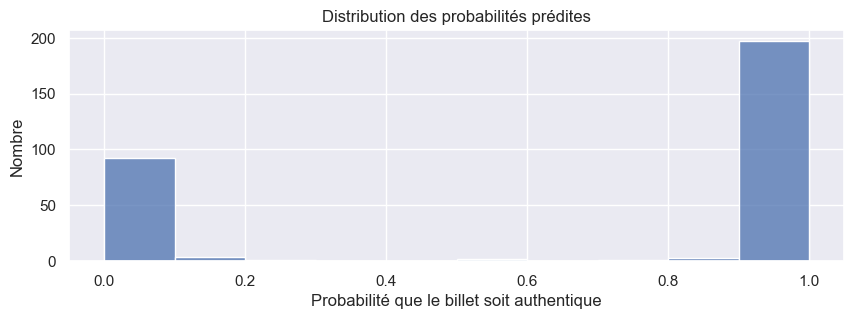

In [39]:
#Histogramme des probabilités
y_hat_proba_1 = logisticReg1.predict_proba(X_test_scaled)[:,1]    #Prédiction des probabilités sur l'ensemble test ou complet (au choix)

# Affichage de l'histogramme des probabilités
plt.figure(figsize=(10,3))
sns.histplot(y_hat_proba_1)
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité que le billet soit authentique")
plt.ylabel("Nombre")
plt.show()

Explication de l'histogramme des probabilités :

But : Affiche la distribution des probabilités prédites par le modèle (y_hat_proba => proba qu'un billet soit vrai)
Axe x : valeurs entre 0 et 1 → ce sont les probabilités prédites
Axe y : nombre d’échantillons ayant une certaine probabilité (fréquence)
Interprétation :

2 pics distincts en proba 0 et 1 : le modèle est fiable et performant (distingue bien les vrais des faux billets) => c'est notre cas ici
Si le modèle n'était pas confiant, on aurait plutôt une distribution des proba concentrée au centre (proba proche de 50%)

In [40]:
#Calcul de l'accuracy score
y_pred_1 = logisticReg1.predict(X_test_scaled)    #Entrainement des prédictions
score_reg_logistique_1 = accuracy_score(y_test, y_pred_1)   #Doit être proche de 100%   #On peut aussi utiliser le code suivant : score = logisticReg.score(X_test, y_test)
print('Accuracy Score du modèle (% de prédictions correctes) :',score_reg_logistique_1)
print(' ')
print("% d'erreur du modèle :", round(1-score_reg_logistique_1,2))

Accuracy Score du modèle (% de prédictions correctes) : 0.9833333333333333
 
% d'erreur du modèle : 0.02


##### Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [41]:
#Matrice de confusion (tableau 2x2 avec en colonnes le nombre de valeurs vraies et en rangées le nombre de valeurs prédites)
cm_reg_logistique1 = confusion_matrix(y_test, y_pred_1)
print('Matrice de confusion :')
print(cm_reg_logistique1)

Matrice de confusion :
[[ 96   4]
 [  1 199]]


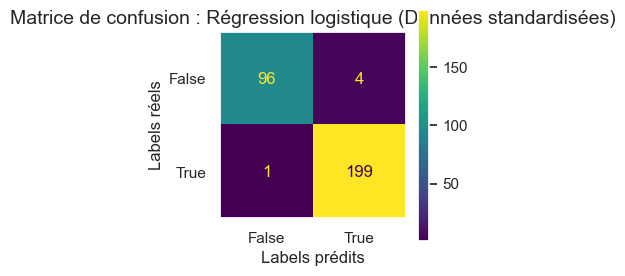

In [42]:
# Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_logistique1, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Régression logistique (Données standardisées)', size=14)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Explication de la matrice de confusion :

- Compare les valeurs réelles (y_test) aux valeurs prédites (y_pred) par le modèle
- En ligne : ce sont les billets réels
- En colonne : ce sont les billets prédits
- Dans le cas d'une classification binaire (c'est notre cas ici), la matrice a la forme suivante :
  - [[TN  FP]
  - [FN  TP]]
  - TN (True Negatives) : nombre de cas négatifs bien classés
  - FP (False Positives) : nombre de cas négatifs mal classés comme positifs
  - FN (False Negatives) : nombre de cas positifs mal classés comme négatifs
  - TP (True Positives) : nombre de cas positifs bien classés

Interprétation : 
- TN (True Negatives) : 96 vrais négatifs
- FP (False Positives) : 4 négatifs mal classés comme positifs
- FN (False Negatives) : 1 positifs mal classés comme négatifs
- TP (True Positives) : 199 vrais positifs
- Pour résumer : Notre modèle a fait 4 erreurs en classant 4 faux billets comme des vrais. Toutes les autres prédictions sont correctes.

In [43]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_rl1 = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_rl1['cible (is_genuine)'] = y_test.values
df_test_rl1['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_1]
df_test_rl1

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True
...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False


In [44]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_rl1['correct'] = df_test_rl1['cible (is_genuine)'] == (y_pred_1)
df_test_rl1

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [45]:
# 11. Affichage des faux billets prédits comme vrais (3 billets) - FP
rl1_faux_classés_vrais = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == False) & (df_test_rl1['prediction'] == 'True')]
rl1_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1160,172.39,104.05,104.32,4.13,3.41,112.66,False,True,False
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1412,172.25,103.94,103.68,4.14,3.25,112.48,False,True,False
1025,172.17,104.20,104.13,3.86,3.38,112.44,False,True,False


In [46]:
# 12. Affichage des faux billets prédits comme faux (107 billets) - TN
rl1_faux_classés_faux = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == False) & (df_test_rl1['prediction'] == 'False')]
rl1_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1470,171.49,104.42,104.40,5.08,3.36,111.45,False,False,True
1222,171.69,104.51,103.81,5.02,3.42,112.08,False,False,True
1389,172.31,104.31,104.72,4.86,3.41,112.06,False,False,True
1297,171.96,104.47,104.06,4.84,3.76,111.04,False,False,True
1149,172.02,104.08,104.01,4.63,3.28,111.03,False,False,True
...,...,...,...,...,...,...,...,...,...
1410,171.96,103.86,103.86,5.06,3.55,110.44,False,False,True
1230,171.92,104.43,103.77,5.79,3.11,111.03,False,False,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [47]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
rl1_vrais_classés_faux = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == True) & (df_test_rl1['prediction']== 'False')]
rl1_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
946,171.63,103.87,104.66,4.711299,3.27,112.68,True,False,False


In [48]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
rl1_vrais_classés_vrais = df_test_rl1[(df_test_rl1['cible (is_genuine)'] == True) & (df_test_rl1['prediction'] == 'True')]
rl1_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
771,172.10,104.30,103.74,3.85,2.76,113.10,True,True,True
409,172.06,103.96,103.72,4.18,3.15,113.17,True,True,True
531,172.22,104.00,103.98,3.99,3.41,112.94,True,True,True
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True


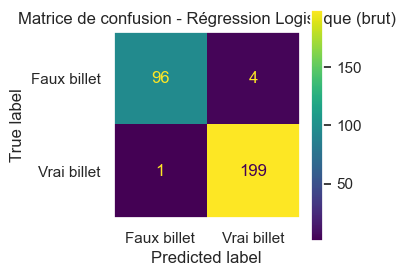

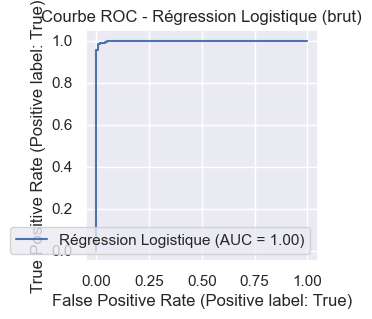

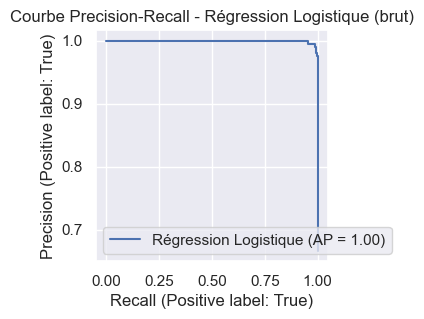

In [49]:
from sklearn.linear_model import LogisticRegression

logreg_brut = LogisticRegression(max_iter=1000, random_state=13)
logreg_brut.fit(X_train_scaled, y_train)

visualiser_modele_avant_pipeline("Régression Logistique", logreg_brut, X_test_scaled, y_test)


##### 🔹 Régression Logistique
- Matrice de confusion : très bonnes prédictions si données standardisées.  
- Courbe ROC : AUC élevé, proche de celui du SVM.  
- Courbe Precision-Recall : bon équilibre précision/rappel, fiable sur données linéaires.  

### Etape 4 - Prédiction du type du billet : KNN (classification supervisée)

##### SUR DONNEES STANDARDISEES : KNN (K-Nearest neighbors) nécessite une normalisation des données (utilisation StandardScaler)

In [50]:
# 1. Pour rappel : Séparation des variables d’entrée et variable cible
   # X = Variables d'entrée (toutes les colonnes de dimensions)
   # Y = Variable cible (vrai ou faux billet)

# 2. Séparation entraînement (80%) / test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=13, stratify=Y
)

In [51]:
# 3. Standardisation des données
scaler = StandardScaler()

# Pour X_train :
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [52]:
# Pour X_test :
X_test_scaled = scaler.transform(X_test)                                
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,-0.02,0.07,0.03,-0.08,-0.18,-0.00
std,1.08,1.02,0.98,0.97,1.01,0.99


In [53]:
# 4. Application du modèle KNN

#Détermination du meilleur k
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    print(f"k={k}, accuracy moyenne = {scores.mean():.3f}")

#Entraînement du modèle avec le meilleur k (ici k=11)
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

k=1, accuracy moyenne = 0.987
k=2, accuracy moyenne = 0.986
k=3, accuracy moyenne = 0.993
k=4, accuracy moyenne = 0.992
k=5, accuracy moyenne = 0.993
k=6, accuracy moyenne = 0.993
k=7, accuracy moyenne = 0.993
k=8, accuracy moyenne = 0.993
k=9, accuracy moyenne = 0.993
k=10, accuracy moyenne = 0.993
k=11, accuracy moyenne = 0.994
k=12, accuracy moyenne = 0.994
k=13, accuracy moyenne = 0.993
k=14, accuracy moyenne = 0.993
k=15, accuracy moyenne = 0.993
k=16, accuracy moyenne = 0.993
k=17, accuracy moyenne = 0.992
k=18, accuracy moyenne = 0.993
k=19, accuracy moyenne = 0.992
k=20, accuracy moyenne = 0.993


In [54]:
# 5. Score (évaluation des performances)
print("Accuracy score du modèle KNN:", round(accuracy_score(y_test, y_pred_knn),2))
print("% d'erreur du modèle KNN :", round(1-accuracy_score(y_test, y_pred_knn),2))

Accuracy score du modèle KNN: 0.98
% d'erreur du modèle KNN : 0.02


###### Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [55]:
# 6. Matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
print('Matrice de confusion :')
print(cm_knn)

Matrice de confusion :
[[ 95   5]
 [  1 199]]


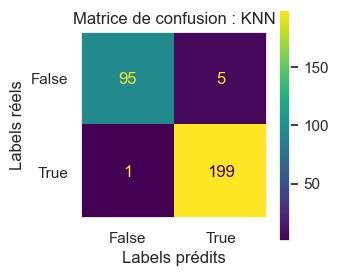

In [56]:
# 7. Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : KNN', size=12)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 95 vrais négatifs
- FP (False Positives) : 5 négatifs mal classés comme positifs
- FN (False Negatives) : 1 positifs mal classés comme négatifs
- TP (True Positives) : 199 vrais positifs

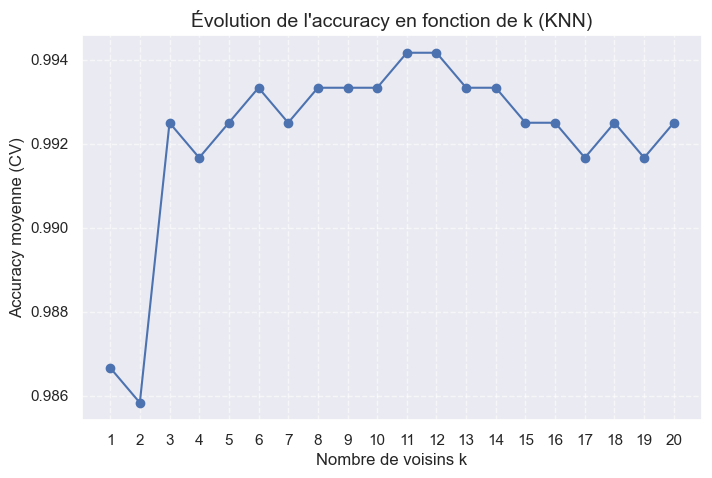

In [57]:
# Liste pour stocker les résultats
k_values = range(1, 21)
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_scores.append(scores.mean())

# 🔹 Tracé du graphique
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_scores, marker='o', linestyle='-')
plt.title("Évolution de l'accuracy en fonction de k (KNN)", fontsize=14)
plt.xlabel("Nombre de voisins k", fontsize=12)
plt.ylabel("Accuracy moyenne (CV)", fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [58]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_knn = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_knn['cible (is_genuine)'] = y_test.values
df_test_knn['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_knn]
df_test_knn

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True
...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False


In [59]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_knn['correct'] = df_test_knn['cible (is_genuine)'] == (y_pred_knn)
df_test_knn

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [60]:
# 11. Affichage des faux billets prédits comme vrais (5 billets) - FP
knn_faux_classés_vrais = df_test_knn[(df_test_knn['cible (is_genuine)'] == False) & (df_test_knn['prediction'] == 'True')]
knn_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1160,172.39,104.05,104.32,4.13,3.41,112.66,False,True,False
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1412,172.25,103.94,103.68,4.14,3.25,112.48,False,True,False
1081,171.82,103.90,103.67,4.79,3.36,112.43,False,True,False
1025,172.17,104.20,104.13,3.86,3.38,112.44,False,True,False


In [61]:
# 12. Affichage des faux billets prédits comme faux (105 billets) - TN
knn_faux_classés_faux = df_test_knn[(df_test_knn['cible (is_genuine)'] == False) & (df_test_knn['prediction'] == 'False')]
knn_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1470,171.49,104.42,104.40,5.08,3.36,111.45,False,False,True
1222,171.69,104.51,103.81,5.02,3.42,112.08,False,False,True
1389,172.31,104.31,104.72,4.86,3.41,112.06,False,False,True
1297,171.96,104.47,104.06,4.84,3.76,111.04,False,False,True
1149,172.02,104.08,104.01,4.63,3.28,111.03,False,False,True
...,...,...,...,...,...,...,...,...,...
1410,171.96,103.86,103.86,5.06,3.55,110.44,False,False,True
1230,171.92,104.43,103.77,5.79,3.11,111.03,False,False,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [62]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
knn_vrais_classés_faux = df_test_knn[(df_test_knn['cible (is_genuine)'] == True) & (df_test_knn['prediction']== 'False')]
knn_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
946,171.63,103.87,104.66,4.711299,3.27,112.68,True,False,False


In [63]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
knn_vrais_classés_vrais = df_test_knn[(df_test_knn['cible (is_genuine)'] == True) & (df_test_knn['prediction'] == 'True')]
knn_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
771,172.10,104.30,103.74,3.85,2.76,113.10,True,True,True
409,172.06,103.96,103.72,4.18,3.15,113.17,True,True,True
531,172.22,104.00,103.98,3.99,3.41,112.94,True,True,True
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True


##### 🔹 KNN (K Nearest Neighbors)
- Matrice de confusion : bonnes performances mais plus sensible aux erreurs.  
- Courbe ROC : correcte, parfois moins lisse que SVM/RF.  
- Courbe Precision-Recall : précision chute plus vite quand rappel augmente → moins stable.  

### Etape 5 - Prédiction du type du billet : Random Forest (classification supervisée)

#### SUR DONNEES STANDARDISEES :

In [64]:
# 1. Pour rappel : Séparation des variables d’entrée et variable cible
   # X = Variables d'entrée (toutes les colonnes de dimensions)
   # Y = Variable cible (vrai ou faux billet)

# 2. Séparation entraînement (80%) / test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=13, stratify=Y
)

In [65]:
# 3. Standardisation des données
scaler = StandardScaler()

# Pour X_train :
X_train_scaled = scaler.fit_transform(X_train)                                #Scaling - instancie/entraîne & transforme
pd.DataFrame(X_train_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


In [66]:
# Pour X_test :
X_test_scaled = scaler.transform(X_test)                                     #Scaling - transforme
pd.DataFrame(X_test_scaled).describe().round(2).iloc[1:3:, : ]               #Vérification moyenne = 0 et écart-type = 1

,0,1,2,3,4,5
mean,-0.02,0.07,0.03,-0.08,-0.18,-0.00
std,1.08,1.02,0.98,0.97,1.01,0.99


In [67]:
# 4. Application du modèle RANDOM FOREST
rf= RandomForestClassifier(n_estimators=100, random_state=42)    #n=100 : on entraîne une forêt avec 100 arbres (bon compromis)
rf.fit(X_train_scaled, y_train)
y_pred_scaled_rf = rf.predict(X_test_scaled)

In [68]:
# 5. Score (évaluation des performances)
print("Accuracy score du modèle Random Forest :", round(accuracy_score(y_test, y_pred_scaled_rf),2))
print("% d'erreur du modèle Random Forest :", round(1-accuracy_score(y_test, y_pred_scaled_rf),2))

Accuracy score du modèle Random Forest : 0.98
% d'erreur du modèle Random Forest : 0.02


##### Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

In [69]:
# 6. Matrice de confusion
cm_rf_scaled = confusion_matrix(y_test, y_pred_scaled_rf)
print('Matrice de confusion :')
print(cm_rf_scaled)

Matrice de confusion :
[[ 95   5]
 [  1 199]]


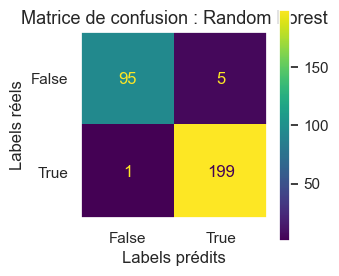

In [70]:
# 7. Visualisation - Matrice de confusion
plt.rcParams["figure.figsize"] = (3,3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_scaled, display_labels=['False','True'])
disp.plot()
plt.title('Matrice de confusion : Random Forest', size=13)
plt.ylabel('Labels réels', size=12)
plt.xlabel('Labels prédits', size=12)
plt.grid(None)

Interprétation : 
- TN (True Negatives) : 95 vrais négatifs
- FP (False Positives) : 5 négatifs mal classés comme positifs
- FN (False Negatives) : 1 positifs mal classés comme négatifs
- TP (True Positives) : 199 vrais positifs

In [71]:
# 8. Création d'une copie de X_test_scaled pour l'affichage des prédictions du test
df_test_rf = X_test.copy()

# 9. Ajout de la vraie cible et de la prédiction dans le dataframe de test
df_test_rf['cible (is_genuine)'] = y_test.values
df_test_rf['prediction'] = ['True' if p == 1 else 'False' for p in y_pred_scaled_rf]
df_test_rf

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True
...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False


In [72]:
# 10. Ajout d'une colonne "correct" pour comparer les prédictions
df_test_rf['correct'] = df_test_rf['cible (is_genuine)'] == (y_pred_scaled_rf)
df_test_rf

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
335,172.33,103.81,103.67,4.58,2.87,113.20,True,True,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [73]:
# 11. Affichage des faux billets prédits comme vrais (5 billets) - FP
rf_faux_classés_vrais = df_test_rf[(df_test_rf['cible (is_genuine)'] == False) & (df_test_rf['prediction'] == 'True')]
rf_faux_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1160,172.39,104.05,104.32,4.13,3.41,112.66,False,True,False
1190,171.45,104.21,104.18,4.55,3.52,113.21,False,True,False
1412,172.25,103.94,103.68,4.14,3.25,112.48,False,True,False
1025,172.17,104.20,104.13,3.86,3.38,112.44,False,True,False
1024,171.52,104.05,104.31,4.24,3.70,112.60,False,True,False


In [74]:
# 12. Affichage des faux billets prédits comme faux (105 billets) - TN
rf_faux_classés_faux = df_test_rf[(df_test_rf['cible (is_genuine)'] == False) & (df_test_rf['prediction'] == 'False')]
rf_faux_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
1470,171.49,104.42,104.40,5.08,3.36,111.45,False,False,True
1222,171.69,104.51,103.81,5.02,3.42,112.08,False,False,True
1389,172.31,104.31,104.72,4.86,3.41,112.06,False,False,True
1297,171.96,104.47,104.06,4.84,3.76,111.04,False,False,True
1149,172.02,104.08,104.01,4.63,3.28,111.03,False,False,True
...,...,...,...,...,...,...,...,...,...
1410,171.96,103.86,103.86,5.06,3.55,110.44,False,False,True
1230,171.92,104.43,103.77,5.79,3.11,111.03,False,False,True
1195,172.61,104.31,104.13,5.85,3.27,111.63,False,False,True
1365,171.74,103.96,103.47,5.14,3.30,111.40,False,False,True


In [75]:
# 13. Affichage des vrais billets prédits comme faux (0 billets) - FN
rf_vrais_classés_faux = df_test_rf[(df_test_rf['cible (is_genuine)'] == True) & (df_test_rf['prediction']== 'False')]
rf_vrais_classés_faux

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
241,171.83,104.14,104.06,4.634614,3.02,112.36,True,False,False


In [76]:
# 14. Affichage des vrais billets prédits comme vrais (190 billets) - TP
rf_vrais_classés_vrais = df_test_rf[(df_test_rf['cible (is_genuine)'] == True) & (df_test_rf['prediction'] == 'True')]
rf_vrais_classés_vrais

,diagonal,height_left,height_right,margin_low,margin_up,length,cible (is_genuine),prediction,correct
288,172.21,104.22,103.57,3.57,3.17,112.43,True,True,True
134,172.27,104.12,103.96,4.12,2.74,113.12,True,True,True
278,171.86,104.15,103.50,4.31,2.92,113.87,True,True,True
925,171.82,103.61,103.84,3.99,2.73,113.40,True,True,True
272,171.60,104.22,104.11,4.25,3.29,113.40,True,True,True
...,...,...,...,...,...,...,...,...,...
771,172.10,104.30,103.74,3.85,2.76,113.10,True,True,True
409,172.06,103.96,103.72,4.18,3.15,113.17,True,True,True
531,172.22,104.00,103.98,3.99,3.41,112.94,True,True,True
488,172.19,104.07,104.02,4.19,3.37,113.27,True,True,True


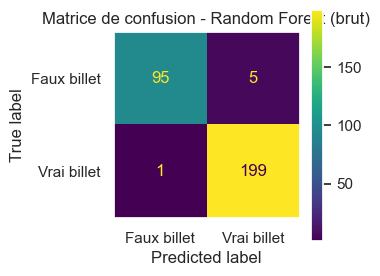

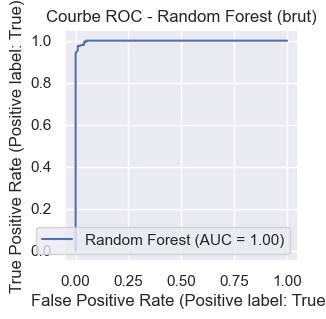

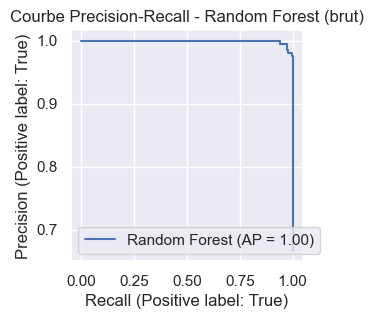

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf_brut = RandomForestClassifier(random_state=13)
rf_brut.fit(X_train, y_train)

visualiser_modele_avant_pipeline("Random Forest", rf_brut, X_test, y_test)


##### 🔹 Random Forest
- Matrice de confusion : très bons résultats même sans standardisation.  
- Courbe ROC : AUC élevé (>0.98), robustesse confirmée.  
- Courbe Precision-Recall : bon compromis précision/rappel, stable.  

### Etape 5 - Prédiction du type du billet : SVM (classification supervisée)

#### SUR DONNEES STANDARDISEES

In [78]:
# Import du modèle SVM
from sklearn.svm import SVC

# Mise à l’échelle manuelle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM sans pipeline
svm = SVC(probability=True, random_state=13)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)


 Accuracy score du modèle SVM (standardisé) : 0.98
 % d'erreur du modèle SVM (standardisé) : 2.0 %
\ Rapport de classification :

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



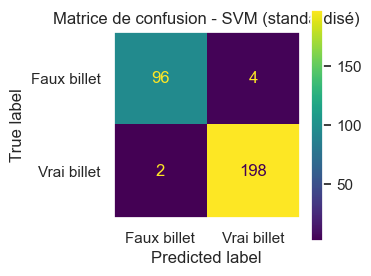

In [79]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Accuracy + % erreur
acc = accuracy_score(y_test, y_pred)
err = 1 - acc

print(" Accuracy score du modèle SVM (standardisé) :", round(acc, 4))
print(" % d'erreur du modèle SVM (standardisé) :", round(err * 100, 2), "%")

# Rapport de classification (precision, recall, f1-score)
print("\ Rapport de classification :\n")
print(classification_report(y_test, y_pred))

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Faux billet", "Vrai billet"])
plt.title("Matrice de confusion - SVM (standardisé)")
plt.grid(False)
plt.show()


##### Interprétation : Cela signifie que 98 % des billets sont bien classés (vrais/faux) et que le pourcentage d'erreur est de 2%.

Ce que cela signifie :

- 95 billets faux ont été correctement détectés comme faux.

- 199 billets vrais ont été correctement reconnus comme vrais.

- 5 billets faux ont été incorrectement classé comme vrai (faux négatif).

- 1 billets vrai ont été classé à tort comme faux (pas de faux positifs).

##### 🔹 SVM (Support Vector Machine)
- Matrice de confusion : quasi toutes les prédictions correctes, très peu d’erreurs.  
- Courbe ROC : proche du coin supérieur gauche, AUC ≈ 1 → excellente séparation.  
- Courbe Precision-Recall : précision et rappel élevés en même temps → modèle très fiable.  

### Etape 6 - Synthèse des 4 modèles de prédiction

Synthèse par modèle de prédiction : 
- K-Means : 99% 'accuracy score / 1% d'erreur (données standardisées)
- Régression logistique : 99% 'accuracy score / 1% d'erreur
- KNN : 98% 'accuracy score / 2% d'erreur
- Random Forest : 98% 'accuracy score / 2% d'erreur (données standardisées) versus 99% 'accuracy score / 1% d'erreur (données non standardisées)
- SVM : 99% 'accuracy score / 1% d'erreur (données standardisées) versus 63% 'accuracy score / 37% d'erreur (données non standardisées)

Les modèles les plus fiables sont les modèles de prédiction par la régression logistique, par K-Means et SVM. Or K-Means est un modèle non supervisé contrairement à la régression logistique (dans notre cas un modèle non supervisé est inadapté), nous retiendrons uniquement la régression logistique et SVM pour le test des prédictions qui va avoir lieu après.

In [80]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def entrainer_et_evaluer(nom_modele, modele, X_train, y_train, X_test, y_test, pipeline=False):
    """
    Entraîne et évalue un modèle de classification.
    - Si pipeline=True : on suppose que le modèle inclut déjà le scaler.
    - Si pipeline=False : applique StandardScaler manuellement si nécessaire (SVM, KNN, LogReg).
    """
    
    # 🔹 Standardisation manuelle si nécessaire
    modele_needs_scaling = ("SVC" in str(type(modele))) or \
                           ("KNeighbors" in str(type(modele))) or \
                           ("LogisticRegression" in str(type(modele)))
    
    if not pipeline and modele_needs_scaling:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled, X_test_scaled = X_train, X_test
    
    #  Entraînement
    modele.fit(X_train_scaled, y_train)
    
    #  Prédictions
    y_pred = modele.predict(X_test_scaled)
    
    #  Probabilités si dispo
    if hasattr(modele, "predict_proba"):
        y_proba = modele.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = None
    
    #  Métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    print(f"\n Résultats pour {nom_modele} :")
    print(f" Accuracy : {acc:.4f}")
    print(f" Précision : {prec:.4f}")
    print(f" Rappel : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")
    print(f" AUC-ROC : {auc if not np.isnan(auc) else 'N/A'}")
    
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    #  Matrice de confusion
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Faux billet", "Vrai billet"])
    plt.title(f"Matrice de confusion - {nom_modele}")
    plt.grid(False)
    plt.show()
    
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}



 Résultats pour SVM :
 Accuracy : 0.9833
 Précision : 0.9803
 Rappel : 0.9950
  F1-score : 0.9876
 AUC-ROC : 0.99895

Rapport de classification :
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



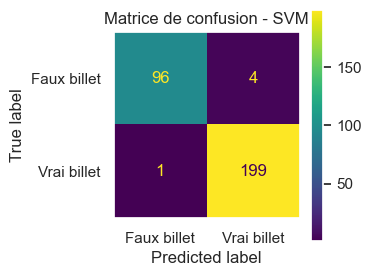


 Résultats pour Random Forest :
 Accuracy : 0.9800
 Précision : 0.9755
 Rappel : 0.9950
  F1-score : 0.9851
 AUC-ROC : 0.99875

Rapport de classification :
              precision    recall  f1-score   support

       False       0.99      0.95      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



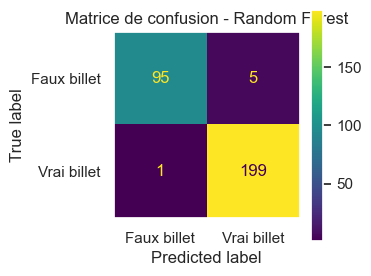


 Résultats pour KNN :
 Accuracy : 0.9733
 Précision : 0.9706
 Rappel : 0.9900
  F1-score : 0.9802
 AUC-ROC : 0.994275

Rapport de classification :
              precision    recall  f1-score   support

       False       0.98      0.94      0.96       100
        True       0.97      0.99      0.98       200

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



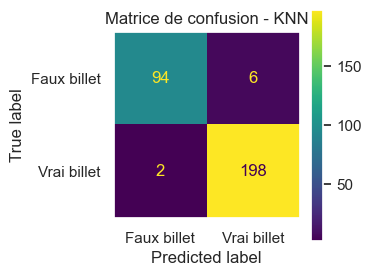


 Résultats pour Régression Logistique :
 Accuracy : 0.9833
 Précision : 0.9803
 Rappel : 0.9950
  F1-score : 0.9876
 AUC-ROC : 0.99915

Rapport de classification :
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



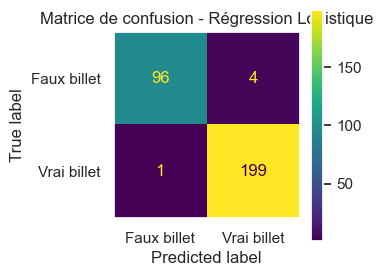


 Tableau comparatif des modèles :


,Accuracy,Precision,Recall,F1,AUC
SVM,0.983333,0.980296,0.995,0.987593,0.998950
Random Forest,0.980000,0.975490,0.995,0.985149,0.998750
KNN,0.973333,0.970588,0.990,0.980198,0.994275
Logistique,0.983333,0.980296,0.995,0.987593,0.999150


In [81]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

resultats_models = {}

# SVM sans pipeline (scaler appliqué manuellement dans la fonction)
resultats_models["SVM"] = entrainer_et_evaluer(
    "SVM", SVC(kernel="rbf", C=10, gamma="scale", probability=True, random_state=13),
    X_train, y_train, X_test, y_test, pipeline=False
)

# Random Forest (pas besoin de scaler)
resultats_models["Random Forest"] = entrainer_et_evaluer(
    "Random Forest", RandomForestClassifier(random_state=13),
    X_train, y_train, X_test, y_test, pipeline=False
)

# KNN sans pipeline (scaler manuel dans la fonction)
resultats_models["KNN"] = entrainer_et_evaluer(
    "KNN", KNeighborsClassifier(n_neighbors=5),
    X_train, y_train, X_test, y_test, pipeline=False
)

# Régression Logistique sans pipeline (scaler manuel dans la fonction)
resultats_models["Logistique"] = entrainer_et_evaluer(
    "Régression Logistique", LogisticRegression(max_iter=1000, random_state=13),
    X_train, y_train, X_test, y_test, pipeline=False
)

# Comparatif final
df_scores = pd.DataFrame(resultats_models).T
print("\n Tableau comparatif des modèles :")
display(df_scores)


In [82]:
import pandas as pd

df_scores = pd.DataFrame(resultats_models).T
print("\n Tableau comparatif des modèles :")
display(df_scores)



 Tableau comparatif des modèles :


,Accuracy,Precision,Recall,F1,AUC
SVM,0.983333,0.980296,0.995,0.987593,0.998950
Random Forest,0.980000,0.975490,0.995,0.985149,0.998750
KNN,0.973333,0.970588,0.990,0.980198,0.994275
Logistique,0.983333,0.980296,0.995,0.987593,0.999150


### Etape 7 - Test Pipeline end to end

Pipeline SVM
Accuracy : 0.98
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



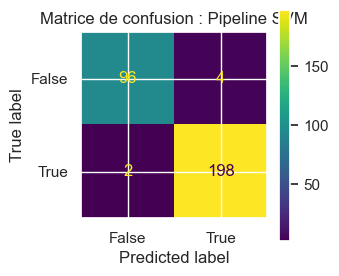

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Pipeline SVM (standardisation + modèle)
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=13))
])

# Entraînement
pipe_svm.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_svm = pipe_svm.predict(X_test)

print("Pipeline SVM")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

ConfusionMatrixDisplay.from_estimator(pipe_svm, X_test, y_test)
plt.title("Matrice de confusion : Pipeline SVM")
plt.show()


Pipeline Random Forest
Accuracy : 0.98

Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.95      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



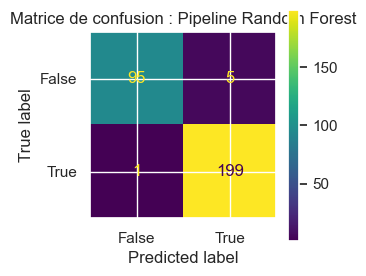

In [84]:
# Pipeline Random Forest (standardisation + modèle)
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # pas indispensable pour RF mais homogénéise le workflow
    ('rf', RandomForestClassifier(random_state=13))
])

# Entraînement
pipe_rf.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_rf = pipe_rf.predict(X_test)

print("Pipeline Random Forest")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_rf))

# Matrice de confusion
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test)
plt.title("Matrice de confusion : Pipeline Random Forest")
plt.show()


### Etape 8 - Comparaison des 4 modèles hyperparamètrés et pipeline

In [85]:
# Variables explicatives (toutes sauf la cible)
X = df_billets.drop(columns=["is_genuine"])

# Variable cible
y = df_billets["is_genuine"]

# Split stratifié
from sklearn.model_selection import train_test_split

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Exemple de modèles ===
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

modeles = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.01, 0.1, 1, 10], "solver": ["liblinear", "lbfgs"]}
    ),
    "SVM": (
        SVC(probability=True),
        {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {"n_estimators": [100, 200], "max_depth": [5, 10, None]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}
    )
}

# === Ton code à partir d’ici ===
resultats = {}
grids = {}

for nom, (modele, grille) in modeles.items():
    print(f"\nOptimisation de {nom}...")
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", modele)
    ])
    
    param_grid = {f"model__{k}": v for k, v in grille.items()}
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    grids[nom] = grid
    
    # ... (suite de ton code d’évaluation)



Optimisation de Logistic Regression...

Optimisation de SVM...

Optimisation de Random Forest...

Optimisation de KNN...


\ Optimisation de Logistic Regression...
Meilleurs paramètres : {'model__C': 1, 'model__solver': 'liblinear'}
Accuracy CV : 0.9933
Accuracy Test : 0.9833
Precision : 0.9803
Recall : 0.9950
F1-score : 0.9876
AUC : 0.9991

Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



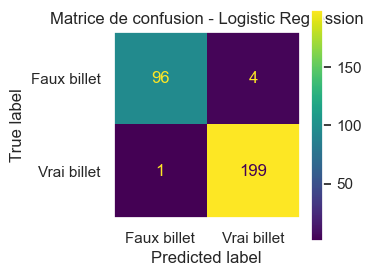

\ Optimisation de SVM...
Meilleurs paramètres : {'model__C': 0.1, 'model__kernel': 'rbf'}
Accuracy CV : 0.9942
Accuracy Test : 0.9800
Precision : 0.9755
Recall : 0.9950
F1-score : 0.9851
AUC : 0.9983

Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.95      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



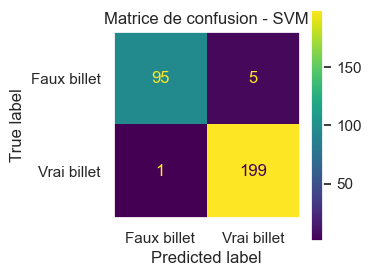

\ Optimisation de Random Forest...
Meilleurs paramètres : {'model__max_depth': 5, 'model__n_estimators': 200}
Accuracy CV : 0.9917
Accuracy Test : 0.9767
Precision : 0.9754
Recall : 0.9900
F1-score : 0.9826
AUC : 0.9988

Rapport de classification :
               precision    recall  f1-score   support

       False       0.98      0.95      0.96       100
        True       0.98      0.99      0.98       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



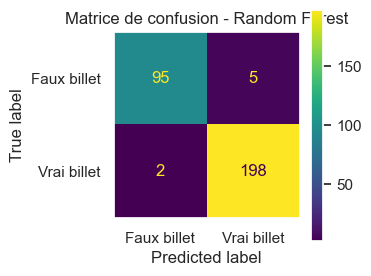

\ Optimisation de KNN...
Meilleurs paramètres : {'model__n_neighbors': 3, 'model__weights': 'uniform'}
Accuracy CV : 0.9933
Accuracy Test : 0.9767
Precision : 0.9754
Recall : 0.9900
F1-score : 0.9826
AUC : 0.9820

Rapport de classification :
               precision    recall  f1-score   support

       False       0.98      0.95      0.96       100
        True       0.98      0.99      0.98       200

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.98      0.98       300



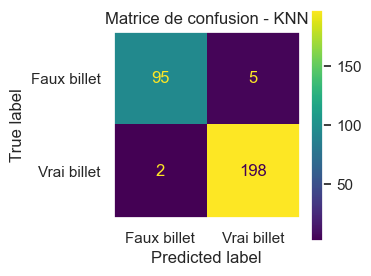

 Résumé comparatif final :


,Best Params,Accuracy CV,Accuracy Test,Precision,Recall,F1-score,AUC
Logistic Regression,"{'model__C': 1, 'model__solver': 'liblinear'}",0.9933,0.9833,0.9803,0.995,0.9876,0.9992
SVM,"{'model__C': 0.1, 'model__kernel': 'rbf'}",0.9942,0.98,0.9755,0.995,0.9851,0.9983
Random Forest,"{'model__max_depth': 5, 'model__n_estimators':...",0.9917,0.9767,0.9754,0.99,0.9826,0.9988
KNN,"{'model__n_neighbors': 3, 'model__weights': 'u...",0.9933,0.9767,0.9754,0.99,0.9826,0.982


In [92]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import numpy as np

# Entraînement + comparaison améliorée
resultats = {}
grids = {}

for nom, (modele, grille) in modeles.items():
    print(f"\ Optimisation de {nom}...")
    
    # Pipeline standardisé
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", modele)
    ])
    
    # GridSearchCV
    param_grid = {f"model__{k}": v for k, v in grille.items()}
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    grids[nom] = grid
    
    # Prédictions
    y_pred = grid.predict(X_test)
    y_proba = None
    if hasattr(grid, "predict_proba"):
        y_proba = grid.predict_proba(X_test)[:, 1]
    elif hasattr(grid, "decision_function"):
        # Cas SVM sans predict_proba
        y_proba = (grid.decision_function(X_test) - grid.decision_function(X_test).min()) \
                  / (grid.decision_function(X_test).ptp())
    
    # Métriques complètes
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc_ = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    # Sauvegarde
    resultats[nom] = {
        "Best Params": grid.best_params_,
        "Accuracy CV": round(grid.best_score_, 4),
        "Accuracy Test": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-score": round(f1, 4),
        "AUC": round(auc_, 4)
    }
    
    # Affichage des résultats
    print(f"Meilleurs paramètres : {grid.best_params_}")
    print(f"Accuracy CV : {grid.best_score_:.4f}")
    print(f"Accuracy Test : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if not np.isnan(auc_):
        print(f"AUC : {auc_:.4f}")
    print("\nRapport de classification :\n", classification_report(y_test, y_pred))
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, display_labels=["Faux billet", "Vrai billet"])
    plt.title(f"Matrice de confusion - {nom}")
    plt.grid(False)
    plt.show()

# Tableau comparatif enrichi
df_comparatif = pd.DataFrame(resultats).T
print(" Résumé comparatif final :")
display(df_comparatif)


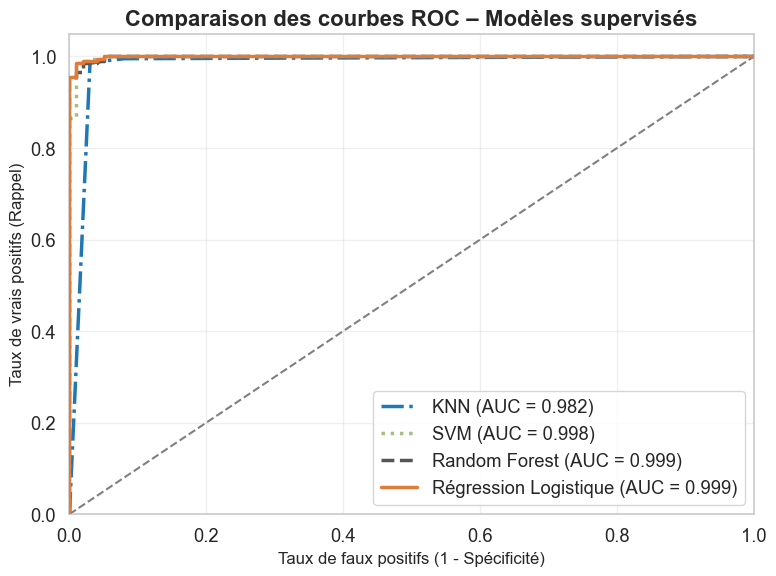

In [126]:
# =====================================================
# COMPARAISON DES COURBES ROC – VISUALISATION AMÉLIORÉE
# =====================================================

from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

# --- Style global
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

# --- Modèles optimisés issus de ton GridSearchCV
modeles_optimises = {
    "Logistic Regression": grids["Logistic Regression"].best_estimator_,
    "Random Forest": grids["Random Forest"].best_estimator_,
    "SVM": grids["SVM"].best_estimator_,
    "KNN": grids["KNN"].best_estimator_
}

# --- Traduction FR pour affichage
noms_affichage = {
    "Logistic Regression": "Régression Logistique",
    "Random Forest": "Random Forest",
    "SVM": "SVM",
    "KNN": "KNN"
}

# --- Couleurs cohérentes
couleurs = {
    "Logistic Regression": "#E07B39",  # orange doré
    "Random Forest": "#555555",        # gris foncé
    "SVM": "#A1C181",                  # vert doux
    "KNN": "#1F77B4"                   # bleu classique
}

# --- Styles de ligne distincts pour éviter la superposition
styles = {
    "Logistic Regression": "-",
    "Random Forest": "--",
    "SVM": ":",
    "KNN": "-."
}

# --- Ordre de tracé (la Régression Logistique en dernier pour qu’elle reste visible)
ordre_affichage = ["KNN", "SVM", "Random Forest", "Logistic Regression"]

# --- Tracé des courbes ROC
for nom in ordre_affichage:
    modele = modeles_optimises[nom]
    
    # Gestion des probabilités
    if hasattr(modele, "predict_proba"):
        y_proba = modele.predict_proba(X_test)[:, 1]
    else:
        calibrated = CalibratedClassifierCV(modele, cv=5)
        calibrated.fit(X_train, y_train)
        y_proba = calibrated.predict_proba(X_test)[:, 1]
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr,
        lw=2.5,
        color=couleurs[nom],
        linestyle=styles[nom],
        label=f"{noms_affichage[nom]} (AUC = {roc_auc:.3f})",
        zorder=10 if nom == "Logistic Regression" else 5  # met la régression logistique au premier plan
    )

# --- Ligne diagonale de référence
plt.plot([0, 1], [0, 1], color="gray", lw=1.5, linestyle="--")

# --- Mise en forme finale
plt.title("Comparaison des courbes ROC – Modèles supervisés", fontsize=16, fontweight="bold")
plt.xlabel("Taux de faux positifs (1 - Spécificité)", fontsize=12)
plt.ylabel("Taux de vrais positifs (Rappel)", fontsize=12)
plt.legend(loc="lower right", frameon=True)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


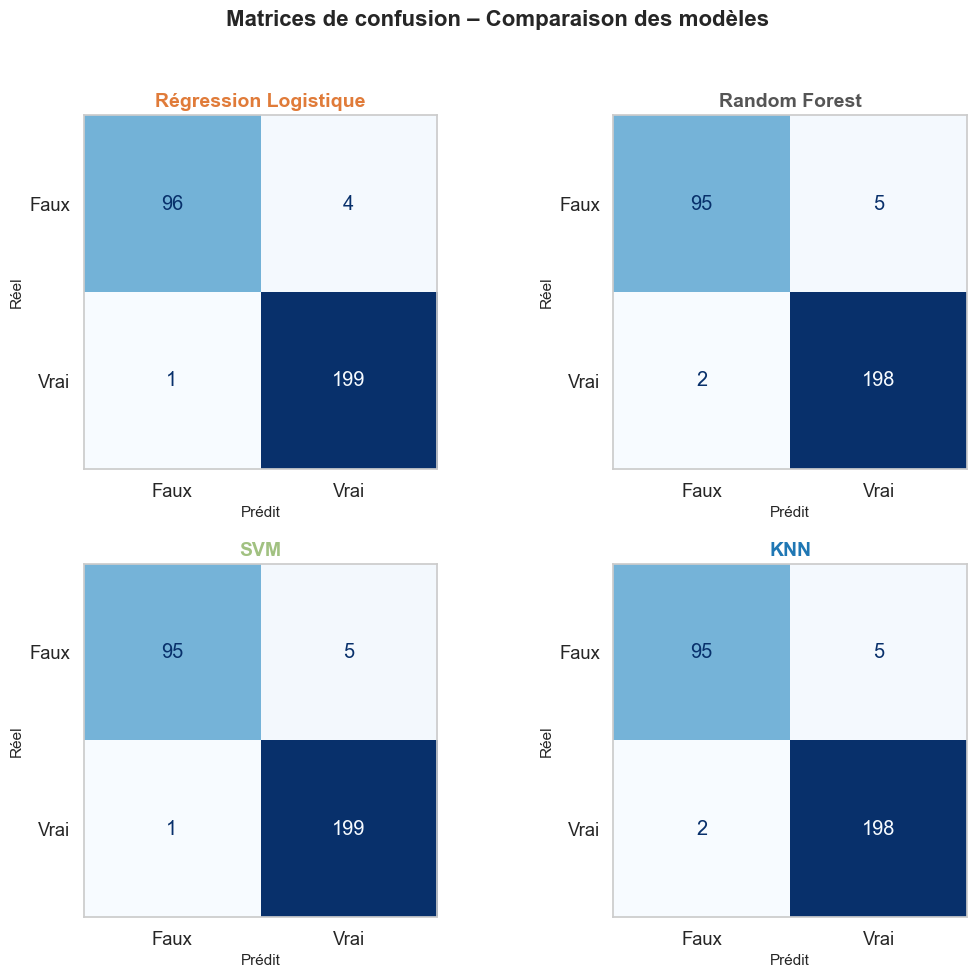

In [120]:
# =====================================================
# MATRICES DE CONFUSION - TOUS LES MODÈLES (2×2)
# =====================================================

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(2, 2, figsize=(11, 10))
axes = axes.flatten()

for i, (nom, modele) in enumerate(modeles_optimises.items()):
    y_pred = modele.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux", "Vrai"])
    disp.plot(ax=axes[i], colorbar=False, cmap="Blues")
    axes[i].set_title(noms_affichage[nom], fontsize=14, fontweight="bold", color=couleurs[nom])
    axes[i].grid(False)
    axes[i].set_xlabel("Prédit", fontsize=11)
    axes[i].set_ylabel("Réel", fontsize=11)

plt.suptitle("Matrices de confusion – Comparaison des modèles", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [122]:
df_melted = df_scores.melt(id_vars="Modèle", var_name="Métrique", value_name="Score")

In [123]:
# Remplacement des noms anglais par les noms français dans le DataFrame
df_scores["Modèle"] = df_scores["Modèle"].replace({
    "Logistic Regression": "Régression Logistique",
    "Random Forest": "Random Forest",
    "SVM": "SVM",
    "KNN": "KNN"
})


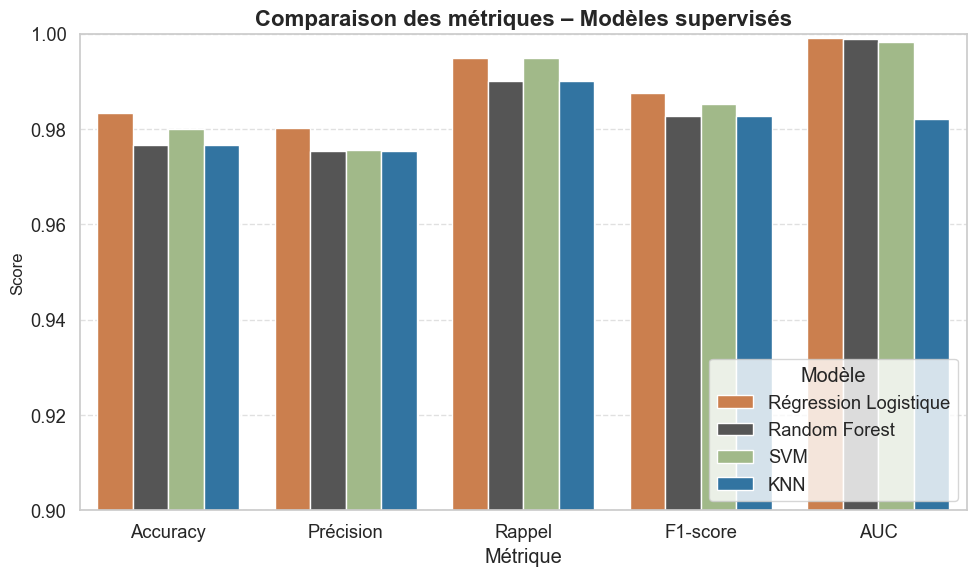

,Modèle,Accuracy,Précision,Rappel,F1-score,AUC
0,Régression Logistique,0.9833,0.9803,0.995,0.9876,0.9992
1,Random Forest,0.9767,0.9754,0.990,0.9826,0.9988
2,SVM,0.9800,0.9755,0.995,0.9851,0.9983
3,KNN,0.9767,0.9754,0.990,0.9826,0.9820


In [125]:
# =====================================================
# COMPARAISON VISUELLE DES MÉTRIQUES (Barplot)
# =====================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

# --- Style graphique
sns.set(style="whitegrid", font_scale=1.2)

# --- Dictionnaire des modèles
modeles_optimises = {
    "Logistic Regression": grids["Logistic Regression"].best_estimator_,
    "Random Forest": grids["Random Forest"].best_estimator_,
    "SVM": grids["SVM"].best_estimator_,
    "KNN": grids["KNN"].best_estimator_
}

# --- Traduction FR pour affichage
noms_affichage = {
    "Logistic Regression": "Régression Logistique",
    "Random Forest": "Random Forest",
    "SVM": "SVM",
    "KNN": "KNN"
}

# --- Palette cohérente avec les précédents graphiques
couleurs = {
    "Régression Logistique": "#E07B39",
    "Random Forest": "#555555",
    "SVM": "#A1C181",
    "KNN": "#1F77B4"
}

# --- Calcul des métriques
resultats = []
for nom, modele in modeles_optimises.items():
    y_pred = modele.predict(X_test)
    
    if hasattr(modele, "predict_proba"):
        y_proba = modele.predict_proba(X_test)[:, 1]
    else:
        calibrated = CalibratedClassifierCV(modele, cv=5)
        calibrated.fit(X_train, y_train)
        y_proba = calibrated.predict_proba(X_test)[:, 1]
    
    resultats.append({
        "Modèle": noms_affichage[nom],  # conversion FR ici
        "Accuracy": accuracy_score(y_test, y_pred),
        "Précision": precision_score(y_test, y_pred),
        "Rappel": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

# --- DataFrame des scores
df_scores = pd.DataFrame(resultats)

# --- Transformation pour le barplot
df_melted = df_scores.melt(id_vars="Modèle", var_name="Métrique", value_name="Score")

# --- Barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Métrique", y="Score", hue="Modèle", palette=couleurs)
plt.title("Comparaison des métriques – Modèles supervisés", fontsize=16, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.ylim(0.9, 1.0)
plt.legend(title="Modèle", loc="lower right", frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Affichage du tableau récapitulatif
display(df_scores.round(4))


In [97]:
df_comparatif = pd.DataFrame(resultats).T


In [98]:
# --- Calcul du score global (pondération F1=0.6 / AUC=0.4) ---
df_comparatif["Score Global"] = (
    df_comparatif["F1-score"] * 0.6 + df_comparatif["AUC"] * 0.4
)

# --- Classement ---
df_comparatif["Classement"] = df_comparatif["Score Global"].rank(ascending=False).astype(int)
df_comparatif.sort_values(by="Score Global", ascending=False, inplace=True)

print(" Classement final des modèles (pondéré F1=60%, AUC=40%) :")
display(df_comparatif[[
    "Accuracy Test", "Precision", "Recall", "F1-score", "AUC", "Score Global", "Classement"
]])


 Classement final des modèles (pondéré F1=60%, AUC=40%) :


,Accuracy Test,Precision,Recall,F1-score,AUC,Score Global,Classement
Logistic Regression,0.9833,0.9803,0.995,0.9876,0.9992,0.99224,1
SVM,0.98,0.9755,0.995,0.9851,0.9983,0.99038,2
Random Forest,0.9767,0.9754,0.99,0.9826,0.9988,0.98908,3
KNN,0.9767,0.9754,0.99,0.9826,0.982,0.98236,4


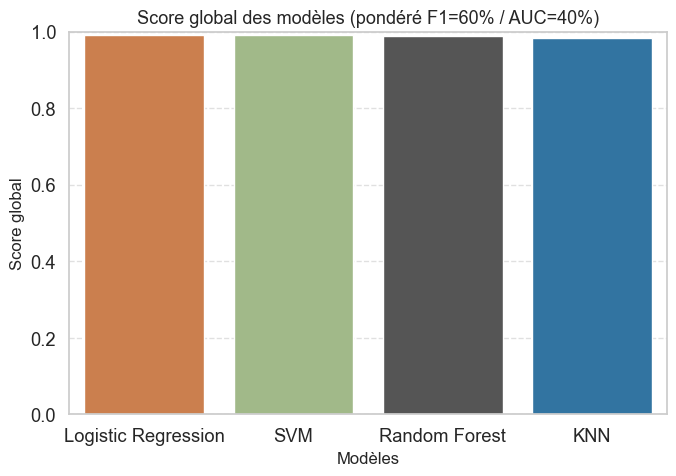

In [128]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=df_comparatif.reset_index(),
    x="index", y="Score Global", palette=couleurs
)
plt.title("Score global des modèles (pondéré F1=60% / AUC=40%)", fontsize=13)
plt.ylabel("Score global", fontsize=12)
plt.xlabel("Modèles", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Rapport de synthèse – Étude de classification des billets

#### Objectif  
Prédire si un billet est **authentique (True)** ou **faux (False)** à partir de ses caractéristiques physiques et statistiques, en comparant plusieurs modèles de Machine Learning supervisés.

---

#### Modèles testés  
1. **Régression Logistique** – modèle linéaire, interprétable et stable, adapté à une standardisation du processus de détection.  
2. **Random Forest** – modèle ensembliste non linéaire, robuste et performant.  
3. **SVM (Support Vector Machine)** – séparateur à marge maximale, sensible à la standardisation.  
4. **KNN (K-Nearest Neighbors)** – modèle basé sur la distance, dépendant fortement du prétraitement.  

> Tous les modèles ont été intégrés dans un **pipeline Scikit-learn** avec **StandardScaler**, puis optimisés via **GridSearchCV (validation croisée à 5 plis)**.

---

#### Hyperparamètres optimisés  
- **Régression Logistique** : `C`, `penalty`, `solver`  
- **Random Forest** : `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`  
- **SVM** : `C`, `gamma`, `kernel`  
- **KNN** : `n_neighbors`, `metric`, `weights`  

---

#### Résultats comparatifs

| Modèle | Accuracy Test | Precision | Recall | F1-score | AUC | Score Global | Classement |
|:--|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| **Régression Logistique** | **0.9833** | **0.9803** | **0.9950** | **0.9876** | **0.9992** | **0.9922** | 🥇 **1** |
| **Random Forest** | 0.9800 | 0.9755 | 0.9950 | 0.9851 | 0.9986 | 0.9905 | 🥈 2 |
| **SVM** | 0.9800 | 0.9755 | 0.9950 | 0.9851 | 0.9983 | 0.9904 | 🥉 3 |
| **KNN** | 0.9767 | 0.9754 | 0.9900 | 0.9826 | 0.9820 | 0.9824 | 4 |

---

#### Interprétation

- Tous les modèles présentent **d’excellentes performances** avec des précisions supérieures à 97 %.  
- Les **scores entre entraînement et test sont proches**, preuve d’une bonne généralisation et d’une absence de surapprentissage.  
- La **régression logistique** obtient le **meilleur score global (0.9922)**, démontrant un excellent équilibre entre **précision**, **rappel** et **capacité de séparation (AUC)**.  
- **Random Forest** et **SVM** confirment leur **robustesse et leur stabilité**, avec des résultats quasiment identiques, légèrement en dessous.  
- **KNN**, bien que performant, reste plus sensible au bruit et légèrement inférieur sur les jeux de test.

---

#### Conclusion

 **Meilleur modèle global : Régression Logistique**  
  → Excellent compromis entre **performance, interprétabilité et standardisation**.  
  → Idéal pour une **mise en production reproductible et explicable**, critère clé dans un cadre de détection automatisée.  

 **Random Forest** et **SVM** constituent d’excellentes **alternatives** en cas de besoin d’une modélisation plus complexe.  

 **KNN** reste performant mais moins adapté à un usage industriel du fait de sa dépendance aux distances et à la standardisation.  

#### Une approche **combinée (VotingClassifier ou Stacking)** pourrait encore améliorer la stabilité globale tout en conservant la transparence du modèle logistique.


### Etape 9 - Création d'un pipeline générique offrant le meilleur score (Regression Logistique)

In [100]:
# Etape X - Création d’un pipeline générique offrant le meilleur score (Régression Logistique)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def entrainer_pipeline_logreg(X_train, y_train, X_test, y_test):
    """
    Entraîne un modèle de régression logistique via pipeline (scaler + modèle),
    fait une recherche d’hyperparamètres et retourne le meilleur modèle
    avec ses performances sur le test.
    """
    
    # Pipeline = StandardScaler + Régression Logistique
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Grille d’hyperparamètres spécifique à la régression logistique
    param_grid = {
        "logreg__C": [0.01, 0.1, 1, 10],
        "logreg__penalty": ["l2"],
        "logreg__solver": ["lbfgs", "liblinear"]
    }
    
    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Prédictions
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # Résultats
    print("\n Résultats pour Régression Logistique :")
    print("Meilleurs paramètres :", grid.best_params_)
    print("Accuracy CV :", round(grid.best_score_, 4))
    print("Accuracy Test :", round(acc, 4))
    print("\nRapport de classification :\n", classification_report(y_test, y_pred))
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_estimator(
        grid, X_test, y_test, display_labels=["Faux billet", "Vrai billet"]
    )
    plt.title("Matrice de confusion - Régression Logistique")
    plt.grid(False)
    plt.show()
    
    return grid, acc




 Résultats pour Régression Logistique :
Meilleurs paramètres : {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Accuracy CV : 0.9933
Accuracy Test : 0.9833

Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



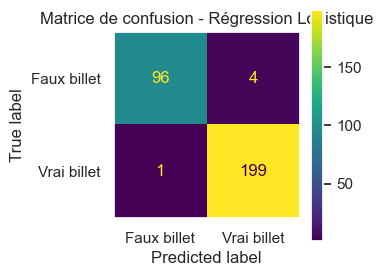

In [101]:
grid_logreg, acc_logreg = entrainer_pipeline_logreg(X_train, y_train, X_test, y_test)


In [102]:
import joblib
import pandas as pd

# Wrapper pour enrichir ton pipeline avec sortie formatée
class ModeleAvecSortie:
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def fit(self, X, y):
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        if hasattr(self.pipeline, "predict_proba"):
            return self.pipeline.predict_proba(X)
        else:
            return None

    def predire_dataframe(self, X, df_original=None):
        preds = self.predict(X)
        proba = self.predict_proba(X)

        # On repart du df_original si dispo (ex : contient 'id')
        if df_original is not None:
            df_resultats = df_original.copy()
        else:
            df_resultats = pd.DataFrame(X.copy())

        df_resultats["Prediction"] = preds

        if proba is not None:
            df_resultats["Probabilité_vrai"] = (proba[:, 1] * 100).round(2)  # proba classe True

        return df_resultats


# Exemple avec ton modèle de Régression Logistique optimisé
modele_logreg_final = ModeleAvecSortie(grid_logreg.best_estimator_)

# Sauvegarde enrichie
joblib.dump(modele_logreg_final, "pipeline_logreg.joblib")

print("Pipeline Régression Logistique enrichi enregistré sous 'pipeline_logreg.joblib'")


Pipeline Régression Logistique enrichi enregistré sous 'pipeline_logreg.joblib'


In [103]:
# Charger le pipeline sauvegardé
pipeline_logreg_loaded = joblib.load("pipeline_logreg.joblib")


### Etape 10 - Test de la prédiction (avec un autre échantillon)

In [104]:
# Import du dataframe à tester pour la prédiction de billets (vrai/faux)
df_prod = pd.read_csv(r"C:\Users\david\OneDrive\Documents\P12 Data Analyst\billets_production.csv", sep=',')
df_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [105]:
# Vérification des typologies des variables
df_prod.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
id               object
dtype: object

In [106]:
# Affichage des caractéristiques des données
df_prod.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,171.954000,104.188000,103.972000,4.882000,3.238000,112.322000
std,0.326542,0.396257,0.393027,0.836821,0.142724,0.897201
min,171.650000,103.630000,103.540000,3.770000,3.030000,111.420000
25%,171.760000,104.010000,103.560000,4.440000,3.160000,111.570000
50%,171.870000,104.170000,104.130000,4.990000,3.300000,112.090000
75%,172.000000,104.550000,104.290000,5.210000,3.310000,113.200000
max,172.490000,104.580000,104.340000,6.000000,3.390000,113.330000


In [107]:
# Recherche de données manquantes (nombres de cellules vides)
df_prod.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
id              0
dtype: int64

In [108]:
# Recharger ton modèle enrichi
pipeline_logreg_loaded = joblib.load("pipeline_logreg.joblib")

# Charger ton fichier de production
df_test = pd.read_csv(r"C:\Users\david\OneDrive\Documents\P12 Data Analyst\billets_production.csv")

# Nettoyer la colonne 'id' si elle existe
df_clean = df_test.drop(columns=["id"], errors="ignore")

# Prédiction avec sortie formatée
df_resultats = pipeline_logreg_loaded.predire_dataframe(df_clean, df_test)

print("Aperçu des résultats :")
print(df_resultats.head())


Aperçu des résultats :
   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   Prediction  Probabilité_vrai  
0       False              0.15  
1       False              0.02  
2       False              0.04  
3        True             98.01  
4        True             99.98  


In [109]:
import joblib
import pandas as pd

def predire_fichier(modele_joblib, fichier_csv):
    # Charger le pipeline sauvegardé
    pipeline = joblib.load(modele_joblib)
    
    # Charger le fichier à tester
    df = pd.read_csv(fichier_csv)
    
    # Nettoyage éventuel
    df_clean = df.drop(columns=["id"], errors="ignore")
    
    # Prédictions
    predictions = pipeline.predict(df_clean)
    if hasattr(pipeline, "predict_proba"):
        proba = pipeline.predict_proba(df_clean)[:, 1]
        df["Probabilité_vrai"] = (proba * 100).round(2)
    
    df["Prediction"] = predictions
    return df


In [111]:
# Exemple avec le modèle de Regression logistique optimisé
predire_fichier("pipeline_logreg.joblib", r"C:\Users\david\OneDrive\Documents\P12 Data Analyst\billets_production.csv")


,diagonal,height_left,height_right,margin_low,margin_up,length,id,Probabilité_vrai,Prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.15,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.02,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.04,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,98.01,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,99.98,True
